In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

# Howto
This notebook shows how to use the LRV test. It is used to test the hypothesis that a set of time series are decorrelated, under the assumption that all the time series have the same spectral density (plus some additional technical assumptions).

## Dataset
We will use the daily returns of the S&P 500 companies over the last 5 years.

In [8]:
dataset_path = Path("./validation/data/snp_returns.csv")

In [9]:
# download the dataset if it does not exist
if not dataset_path.exists():
    # extract the list of S&P 500 companies from wikipedia
    wikipedia_data = pd.read_html(
        "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    )
    snp_company_list, snp_changes = wikipedia_data[0], wikipedia_data[1]
    snp_ticker_symbols = snp_company_list.Symbol.tolist()

    # download the close prices from yahoo finance
    data = yf.download(tickers=snp_ticker_symbols, period="5y", interval="1d")
    prices = data["Adj Close"]

    # compute the returns. Keep only the instruments with no NaN values
    prices = prices.dropna(axis=1, how="any")
    returns = np.log(prices).diff().dropna(axis=0, how="any")

    # dump returns as csv. Create folder if it does not exist
    if not dataset_path.parent.exists():
        dataset_path.parent.mkdir(parents=True)
    returns.to_csv(dataset_path)

# load the csv
returns = pd.read_csv(dataset_path, index_col=0)

[*********************100%***********************]  503 of 503 completed

9 Failed downloads:
['BRK.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')
['KVUE', 'GEHC', 'VLTO']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']")
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=5y)')
['GEV', 'SOLV']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']")
['SW']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']")
['AMTM']: YFInvalidPeriodError("%ticker%: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']")


In [10]:
returns.shape

(1257, 489)

In [11]:
# standardize the returns for each instrument
snp_ticker_symbols = returns.columns.tolist()
standardized_returns = {}
a_is, b_is, beta_is = {}, {}, {}
for ticker in snp_ticker_symbols:
    rs = returns[ticker]
    a_i = np.mean(rs)
    b_i = np.std(rs)
    standardized_returns[ticker] = (rs - a_i) / b_i
    a_is[ticker] = a_i
    b_is[ticker] = b_i

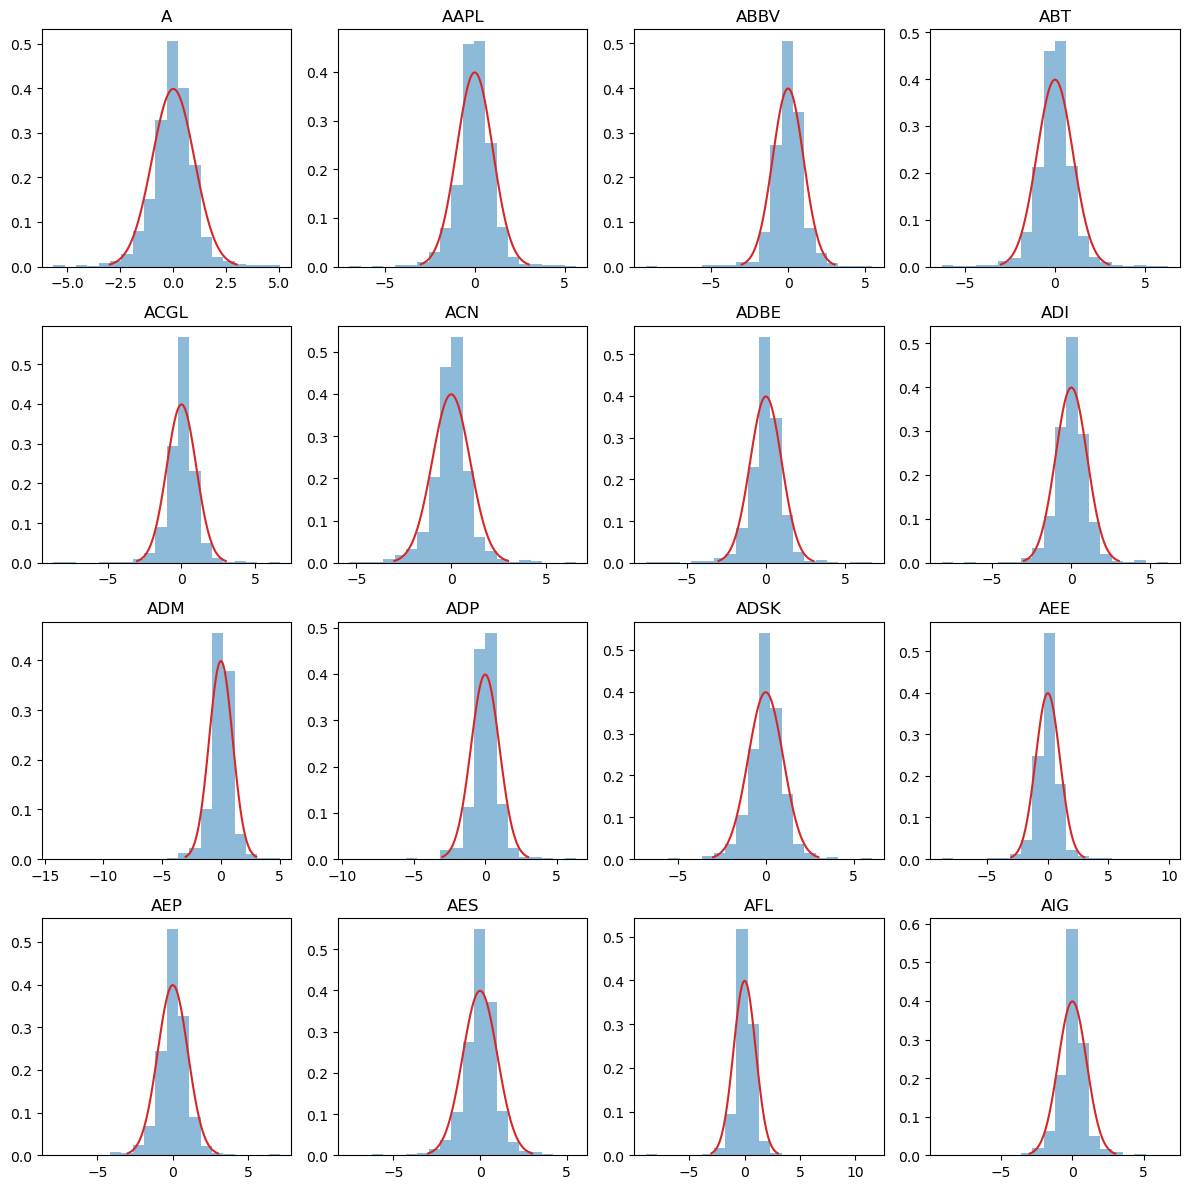

In [12]:
# plot for the first few instruments the standardize returns distribution against the gaussian with mean a_i and std b_i

n_graphs_to_plot = 4
fig, axs = plt.subplots(
    n_graphs_to_plot,
    n_graphs_to_plot,
    figsize=(3 * n_graphs_to_plot, 3 * n_graphs_to_plot),
)
# flatten the axs array
axs = axs.flatten()

# compute the gaussian pdf
x = np.linspace(-3, 3, 100)
gaussian_pdf = norm.pdf(x)

for i, ticker in enumerate(snp_ticker_symbols[: n_graphs_to_plot**2]):
    rs = standardized_returns[ticker]
    ax = axs[i]
    ax.hist(rs, bins=20, alpha=0.5, density=True)
    ax.plot(x, gaussian_pdf, label="Gaussian", color="tab:red")
    ax.set_title(ticker)

plt.tight_layout()
plt.show()

In [13]:
# convert returns to a 2D numpy array,
standardized_returns_np = np.array(
    [standardized_returns[ticker] for ticker in snp_ticker_symbols]
).T

## LRV test
In this section, we run the LRV test against 50 randomly selected companies.

In [14]:
from lrv_test import LRV, LRVResult

B = 51
L = 5
f = lambda x: (x - 1) ** 2
freqs = np.arange(-0.5, 0.5, 0.1)

# select randomly 50 companies, repeat 10 times
results: list[LRVResult] = []
n_companies = 50
for _ in tqdm(range(10)):
    companies_idx = np.random.choice(
        standardized_returns_np.shape[1], n_companies, replace=False
    )
    selected_standardized_returns_np = standardized_returns_np[:, companies_idx]

    # the null hypothesis (the daily returns of the selected comparnies are independent) is rejected
    lrv_results = LRV(selected_standardized_returns_np, B, f, freqs, L)
    results.append(lrv_results)

100%|██████████| 10/10 [00:00<00:00, 30.98it/s]


In [15]:
[result.t_stat_2 for result in results]

[np.float64(223365.08826328008),
 np.float64(190787.37152021704),
 np.float64(216941.65755878133),
 np.float64(168850.11618074897),
 np.float64(238855.12634555704),
 np.float64(249782.57174990358),
 np.float64(161888.17853657843),
 np.float64(162892.62264067036),
 np.float64(214868.35631331292),
 np.float64(172177.80536066176)]

In [16]:
level = 0.05
[result.is_positive_0(level, alternative="double") for result in results]

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True])]

In [17]:
[result.is_positive_1(level, alternative="double") for result in results]

[np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_]

In [18]:
[result.is_positive_2(level, alternative="double") for result in results]

[np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_]

In [19]:
[result.is_positive_3(level, alternative="right") for result in results]

[np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_]

In [20]:
[result.is_positive_4(level, alternative="right") for result in results]

[np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_]